<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

#from google.colab import files

In [2]:
style_path = "images/style.jpg"
content_path = "images/input.jpg"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [3]:
# After the images are uploaded on to the local filesystem, you can use:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


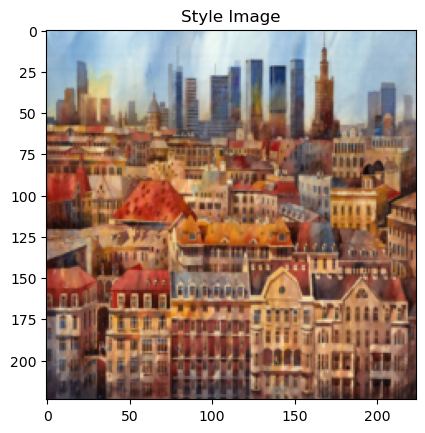

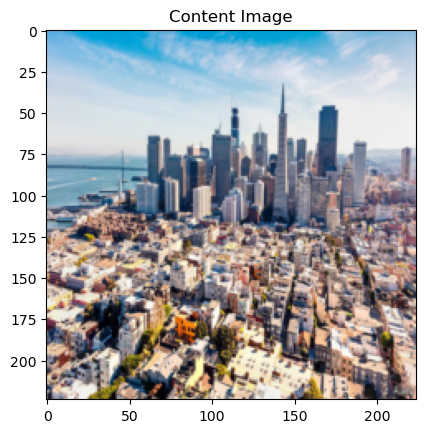

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

content_layer = ["conv2_2"]
style_layers = ["conv1_2", "conv2_2", "conv3_3", "conv4_3", "conv5_3"]
# Choose the layers to use for style and content transfer
content_layer_idx = [vgg_names.index(name) for name in content_layer] 
style_layers_idx = [vgg_names.index(name) for name in style_layers]

# Create the vgg network in eval mode
vgg = VGGIntermediate(requested=content_layer_idx+style_layers_idx).eval().cuda()
#  with our forward method that returns the outputs of the intermediate layers we requested

# Cache the outputs of the content and style layers for their respective images
content_feature = vgg(content_image)[content_layer_idx[0]]

style_features = vgg(style_image)




C:\Users\Johnson\AppData\Local\Temp\ipykernel_24224\2776760186.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Johnson\AppData\Local\Temp\ipykernel_24224\2776760186.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)
c:\Users\Johnson\miniconda3\envs\data\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Johnson\miniconda3\envs\data\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or

___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [12]:
STYLE_WEIGHT = 1
CONTENT_WEIGHT = 1
TOT_VAR_WEIGHT = 1# 1e-4

def gram_matrix(input):
   i = input.squeeze(0).flatten(1,2)
   return i.matmul(i.T)

#style_gram = {gram_matrix(style_features[i]) for i in style_layers_idx}
#STYLE_ELEM = sum([style_gram[i].numel() for i in style_gram])

class ContentLoss(nn.Module):
  def __init__(self, content_feature):
    super(ContentLoss, self).__init__()
    self.content_feature = content_feature.detach()

  def forward(self, combination):
    return CONTENT_WEIGHT*torch.sum(torch.square(combination - self.content_feature))
    
class StyleLoss(nn.Module):
  def __init__(self, style_gram):
    super(StyleLoss, self).__init__()
    self.style_gram = style_gram

  def forward(self,combination):
    return STYLE_WEIGHT*torch.mean(torch.square(gram_matrix(combination) - self.style_gram))
    #normalize this???!

class TotVarLoss(nn.Module):
  def __init__(self):
    super(TotVarLoss, self).__init__()

  def forward(self, combination):
    return TOT_VAR_WEIGHT*(torch.sum(torch.abs(combination[:, :, :, :-1] - combination[:, :, :, 1:])) + torch.sum(torch.abs(combination[:, :, :-1, :] - combination[:, :, 1:, :])))



class TotalLoss(nn.Module):
  def __init__(self, content_feature, style_features):
    super(TotalLoss, self).__init__()
    self.CLossMod = ContentLoss(content_feature)
    self.SLossMod = {k : StyleLoss(gram_matrix(style_features[k].detach())) for k in style_layers_idx}
    self.TotVarLossMod = TotVarLoss()

  def forward(self, combination):
    return self.CLossMod(combination[content_layer_idx[0]]) + sum([self.SLossMod[k](combination[k]) for k in style_layers_idx]) + self.TotVarLossMod(combination[content_layer_idx[0]])

totLoss = TotalLoss(content_feature, style_features).cuda()

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison




___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



0 31255001088.0
50 589160384.0
100 251500624.0
150 144637312.0
200 106731456.0
250 94362320.0
300 76959144.0
350 72582896.0
400 84250848.0
450 64716640.0
500 55918456.0
550 54390536.0
600 50024184.0
650 62236216.0
700 246428208.0
750 76058512.0
800 53659960.0
850 47043592.0
900 45621964.0
950 44169144.0


C:\Users\Johnson\AppData\Local\Temp\ipykernel_24224\3303199995.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


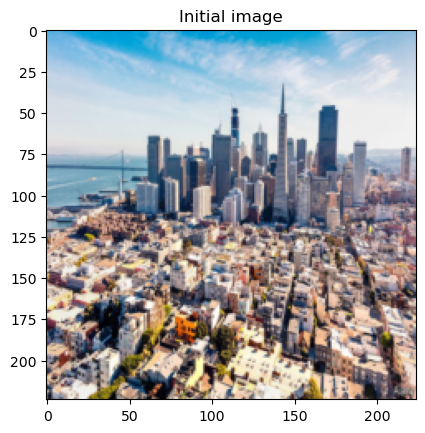

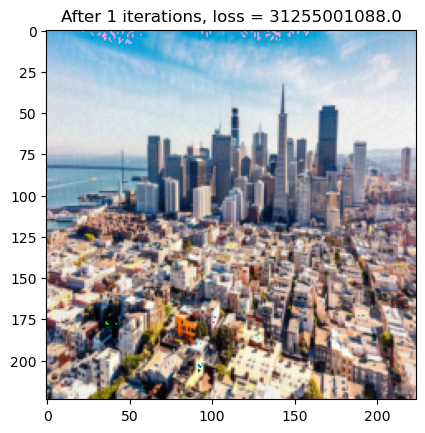

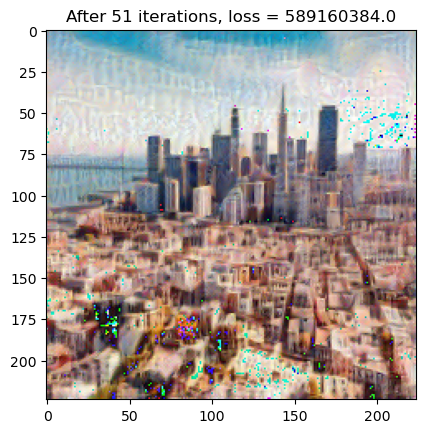

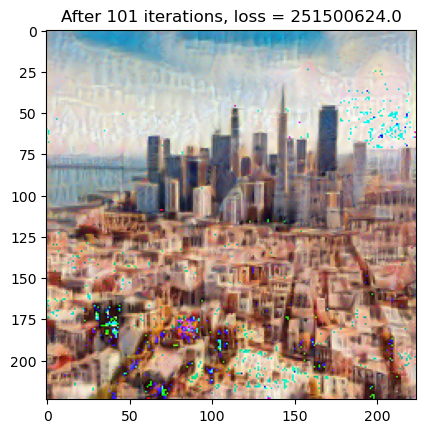

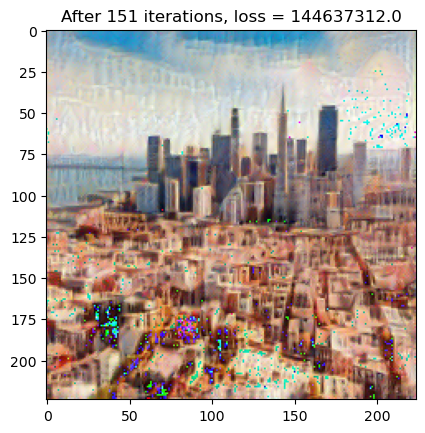

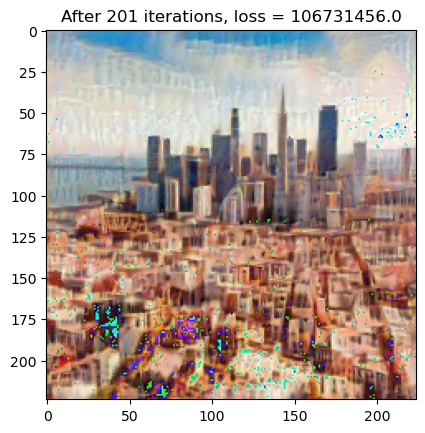

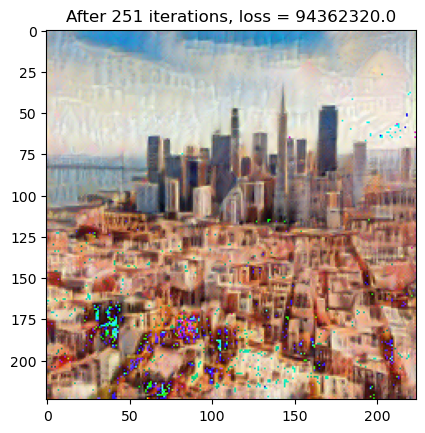

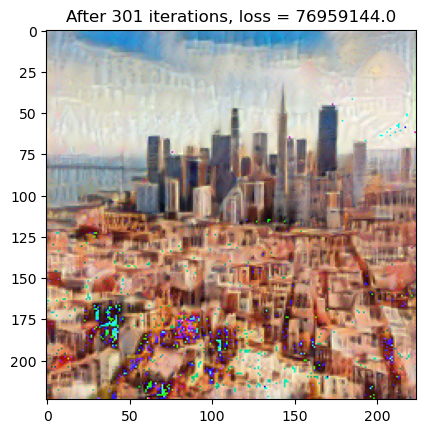

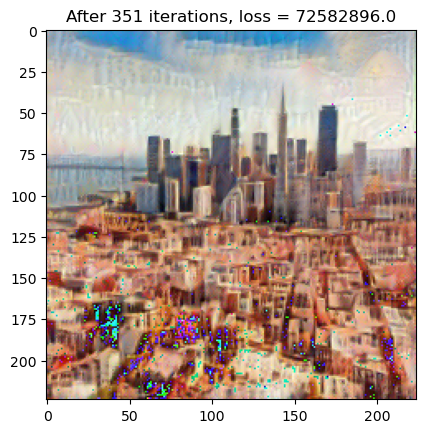

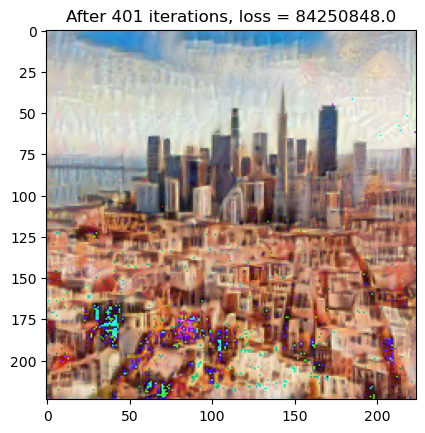

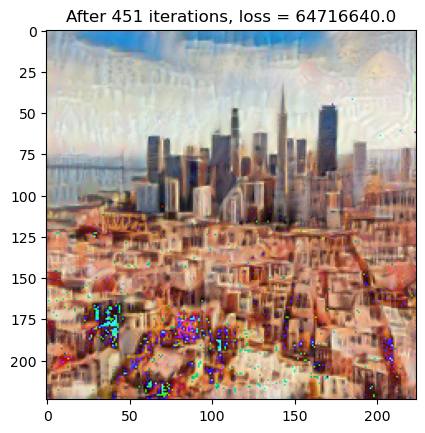

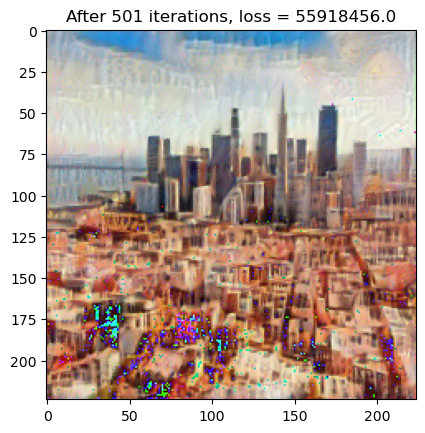

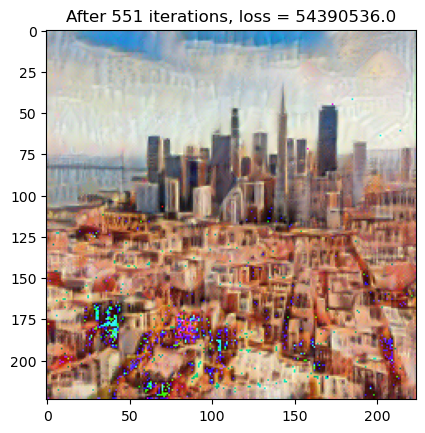

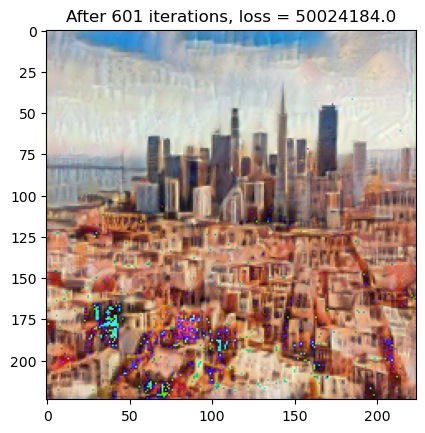

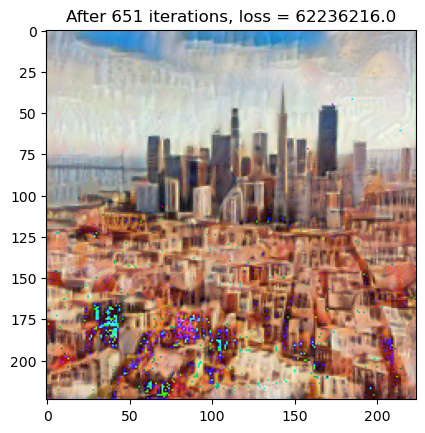

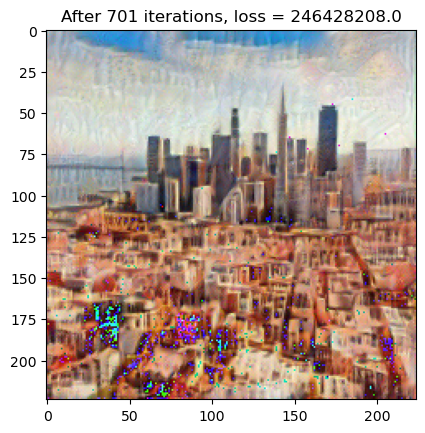

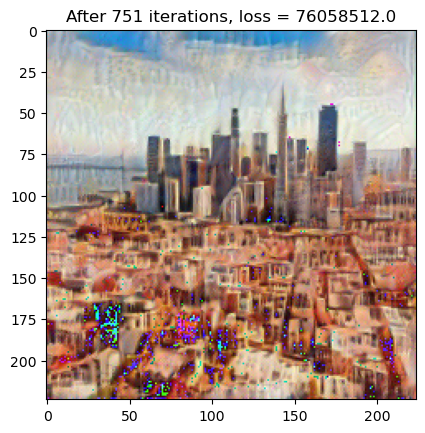

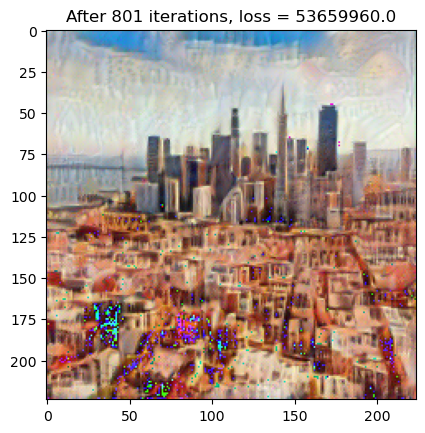

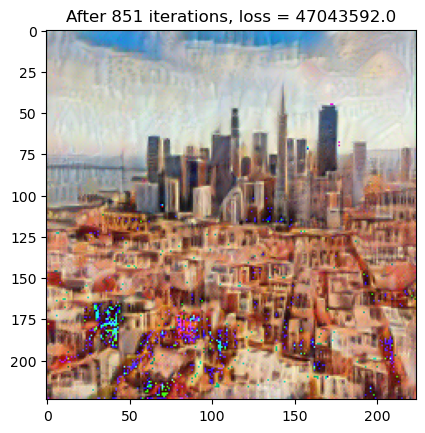

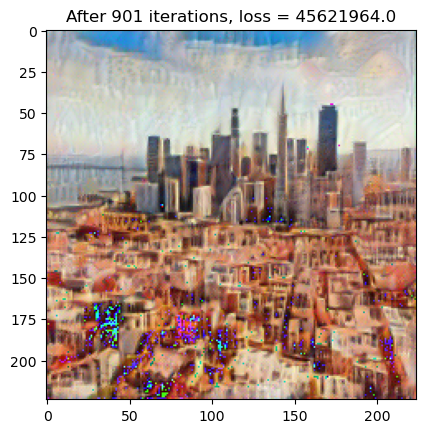

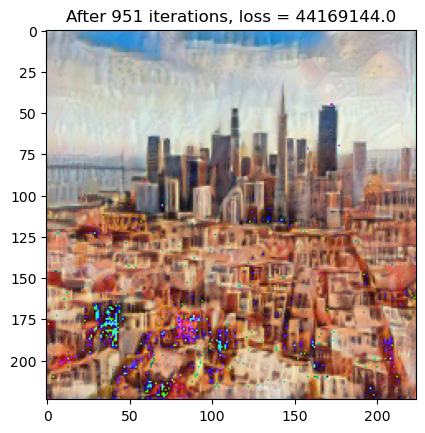

In [13]:
# Start with a copy of the content image
#  and make it a parameter that requires a gradient
content_image_orig_r = Image.open(content_path)
combination = load_and_normalize(np.array(content_image_orig_r)).unsqueeze(0).cuda().requires_grad_(True)

#combination = content_image.clone().requires_grad_(True).cuda()
display(combination, "Initial image")

# Create an optimizer to change the image
#  using the loss of the style and content layers
#  to backpropagate errors
optimizer = optim.Adam([combination], lr=0.01)


for i in range(1000):
    optimizer.zero_grad()
    features = vgg(combination)

    #loss = sum(f.sum() for f in features.values())
    loss = totLoss(features)
    #print("loss", loss)
    loss.backward()

    optimizer.step()

    #with torch.no_grad():
    #    combination = torch.clamp(combination, 0, 1)



    if i % 50 == 0:
        print(i,loss.item())
        plt.figure()
        display(combination, f"After {i+1} iterations, loss = {loss}")


# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
  
# Show the image

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

In [9]:
content_image.min()

tensor(0., device='cuda:0')